In [1]:
import torch
from datasets import load_dataset, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from config import load_config, get_model_name
config = load_config("vq_vae")

train_loader, test_loader, val_loader = load_dataset(config["data_params"])

model_name = get_model_name(config)

In [2]:
from models import VQVAE
import pytorch_lightning as pl
from trainers import BaseModule

class VAETrainer(BaseModule):
    def __init__(self, num_embeddings, embedding_dim):
        model = VQVAE(num_embeddings, embedding_dim)
        super(VAETrainer, self).__init__(model)
        self.save_hyperparameters()
        
    def forward(self, x, x_cond, y):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices = self(x, x_cond, y)
        loss = self.model.loss(latent, quantized, x_hat, x)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True, prog_bar=True)
        return loss['loss']
    
    def decode(self, z):
        return self.model.decode(z)
    
    def load_model_checkpoint(model_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return VAETrainer.load_from_checkpoint(path)
    

In [3]:
model = VAETrainer(**config['model_params'])

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name=model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 92.53it/s, v_num=0, train_loss=0.401, train_recon_loss=0.0817, train_vq_loss=0.320, train_commitment_loss=0.213, train_embeddding_loss=0.213, val_loss=0.392, val_recon_loss=0.0796, val_vq_loss=0.312, val_commitment_loss=0.208, val_embeddding_loss=0.208] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 92.48it/s, v_num=0, train_loss=0.401, train_recon_loss=0.0817, train_vq_loss=0.320, train_commitment_loss=0.213, train_embeddding_loss=0.213, val_loss=0.392, val_recon_loss=0.0796, val_vq_loss=0.312, val_commitment_loss=0.208, val_embeddding_loss=0.208]


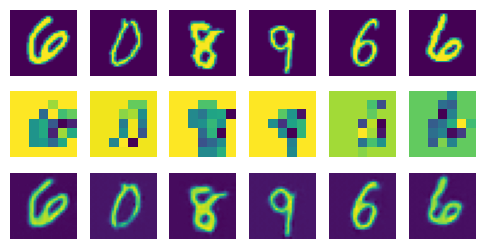

In [3]:
model = VAETrainer.load_model_checkpoint(model_name)

from plotting import plot_samples_with_reconstruction_and_indices
plot_samples_with_reconstruction_and_indices(model, next(iter(test_loader)))

In [3]:
from models.autoregresive import PixelCNN, SimplePixelCNN
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

pixel_cnn_model_name = "pixel_cnn_" + model_name

class PixelCNNTrainer(BaseModule):
    def __init__(self, vae_name):

        # vae does not require to be trained and saved
        vae = VAETrainer.load_model_checkpoint(vae_name)
        vae.freeze()
        vae.eval()

        model = SimplePixelCNN()
        super(PixelCNNTrainer, self).__init__(model)
        self.vae = vae
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, quantized, latent, embedding_indices= self.vae(x, x_cond, y)
        
        # reshape back embedding indices and detach from graph
        embedding_indices = embedding_indices.reshape(shape=(latent.shape[0], 1, latent.shape[2], latent.shape[3]))
        target = Variable(embedding_indices[:,0,:,:]).long() 

        logits = self(embedding_indices.float())

        loss = self.criterion(logits, target)
        self.log(f"{mode}_loss", loss, prog_bar=True)
        return loss

    def load_model_checkpoint(model_name, vae_name):
        path = ('checkpoints/' + model_name + '.ckpt')
        return PixelCNNTrainer.load_from_checkpoint(path, vae_name = vae_name, map_location = 'cpu')
    

In [5]:
model = PixelCNNTrainer(vae_name=model_name)

from trainers import SuperTrainer
trainer = SuperTrainer(**config['trainer_params'], model_name = pixel_cnn_model_name)
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_model_checkpoint()

/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Home/siv34/edzak2974/.conda/envs/pytorch_masters/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /Home/siv34/edzak2974/.conda/envs/pytorch_masters/li ...
  rank_zero_warn(
You are using a CUDA device ('A100-S

Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 90.05it/s, v_num=0, train_loss=0.866, val_loss=0.934] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 469/469 [00:05<00:00, 89.02it/s, v_num=0, train_loss=0.866, val_loss=0.934]


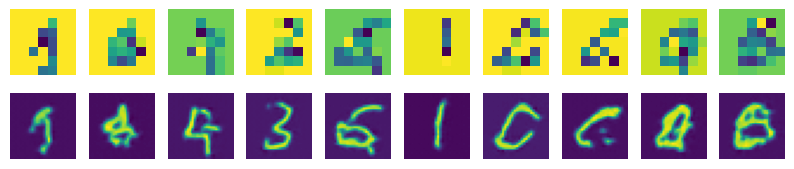

In [4]:
model = PixelCNNTrainer.load_model_checkpoint(pixel_cnn_model_name, vae_name = model_name)
from plotting import generate_indices_and_reconstruct
        
generate_indices_and_reconstruct(model)
